In [1]:
import gym
import matplotlib.pyplot as plt

import rl # Init environment

In [2]:
env = gym.make("Gridworld-v0")

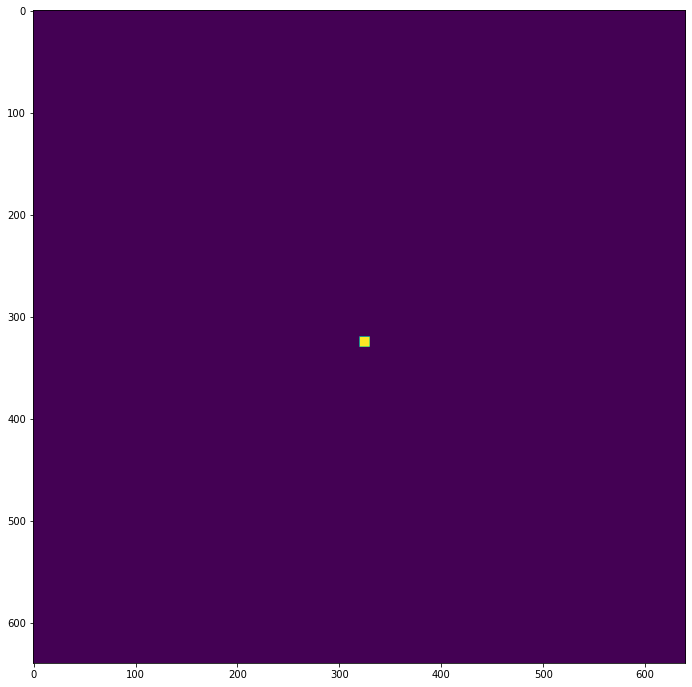

In [3]:
plt.figure(figsize=(12, 12))
env.reset()
plt.imshow(env.render())